# Distributed DeepRacer RL training with SageMaker and RoboMaker

---
## Introduction


In this notebook, we will train a fully autonomous 1/18th scale race car using reinforcement learning using Amazon SageMaker RL and AWS RoboMaker's 3D driving simulator. [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) is a service that makes it easy for developers to develop, test, and deploy robotics applications.  

This notebook provides a jailbreak experience of [AWS DeepRacer](https://console.aws.amazon.com/deepracer/home#welcome), giving us more control over the training/simulation process and RL algorithm tuning.

![Training in Action](./deepracer-reinvent-track.jpg)


---
## How it works?  

![How training works](./training.png)

The reinforcement learning agent (i.e. our autonomous car) learns to drive by interacting with its environment, e.g., the track, by taking an action in a given state to maximize the expected reward. The agent learns the optimal plan of actions in training by trial-and-error through repeated episodes.  
  
The figure above shows an example of distributed RL training across SageMaker and two RoboMaker simulation envrionments that perform the **rollouts** - execute a fixed number of episodes using the current model or policy. The rollouts collect agent experiences (state-transition tuples) and share this data with SageMaker for training. SageMaker updates the model policy which is then used to execute the next sequence of rollouts. This training loop continues until the model converges, i.e. the car learns to drive and stops going off-track. More formally, we can define the problem in terms of the following:  

1. **Objective**: Learn to drive autonomously by staying close to the center of the track.
2. **Environment**: A 3D driving simulator hosted on AWS RoboMaker.
3. **State**: The driving POV image captured by the car's head camera, as shown in the illustration above.
4. **Action**: Six discrete steering wheel positions at different angles (configurable)
5. **Reward**: Positive reward for staying close to the center line; High penalty for going off-track. This is configurable and can be made more complex (for e.g. steering penalty can be added).

## Prequisites

### Run these command if you wish to modify the SageMaker and Robomaker code
<span style="color:red">Note: Make sure you have atleast 25 GB of space when you are planning to modify the Sagemaker and Robomaker code</span>

In [77]:
#
# Run these commands only for the first time
#
# Clean the build directory if present
!python3 sim_app_bundler.py --clean

# Download Robomaker simApp from the deepracer public s3 bucket
simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
!aws s3 cp {simulation_application_bundle_location} ./

# Untar the simapp bundle
!python3 sim_app_bundler.py --untar ./deepracer-simapp.tar.gz

# Now modify the simapp(Robomaker) from build directory and run this command.

# Most of the simapp files can be found here (Robomaker changes). You can modify them in these locations
# bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/
# bundle/opt/install/deepracer_simulation_environment/share/deepracer_simulation_environment/
# bundle/opt/install/deepracer_simulation_environment/lib/deepracer_simulation_environment/

# # Copying the notebook src/markov changes to the simapp (For sagemaker container)
!rsync -av ./src/markov/ ./build/simapp/bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/markov

print("############################################")
print("This command execution takes around >2 min...")
!python3 sim_app_bundler.py --tar

Deleting all files in ./build
download: s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz to ./deepracer-simapp.tar.gz
Untarring all files in ./build/simapp/
tar -xvf ./deepracer-simapp.tar.gz -C build/simapp/
tar -xvf build/simapp/bundle.tar -C build/simapp/bundle
tar -xvf build/simapp/metadata.tar -C build/simapp/
sending incremental file list
./
__init__.py
camera_utils.py
common.py
constants.py
deepracer_memory.py
defaults.py
evaluation_worker.py
rollout_constants.py
rollout_utils.py
rollout_worker.py
rospy_wrappers.py
s3_boto_data_store.py
sagemaker_graph_manager.py
training_worker.py
utils.py
validation_worker.py
virtual_event_worker.py
__pycache__/
__pycache__/__init__.cpython-35.pyc
__pycache__/camera_utils.cpython-35.pyc
__pycache__/common.cpython-35.pyc
__pycache__/constants.cpython-35.pyc
__pycache__/deepracer_memory.cpython-35.pyc
__pycache__/defaults.cpython-35.pyc
__pycache__/evaluation_worker.cpython-35.pyc
__pycache__/rollout_constants.cpython-35.pyc
__

multi_agent_coach/agents/
multi_agent_coach/agents/__init__.py
multi_agent_coach/agents/sac_agent.py
multi_agent_coach/agents/__pycache__/
multi_agent_coach/agents/__pycache__/__init__.cpython-35.pyc
multi_agent_coach/agents/__pycache__/sac_agent.cpython-35.pyc
multi_agent_coach/architectures/
multi_agent_coach/architectures/__init__.py
multi_agent_coach/architectures/head_parameters.py
multi_agent_coach/architectures/__pycache__/
multi_agent_coach/architectures/__pycache__/__init__.cpython-35.pyc
multi_agent_coach/architectures/__pycache__/head_parameters.cpython-35.pyc
multi_agent_coach/architectures/tensorflow_components/
multi_agent_coach/architectures/tensorflow_components/__init__.py
multi_agent_coach/architectures/tensorflow_components/__pycache__/
multi_agent_coach/architectures/tensorflow_components/__pycache__/__init__.cpython-35.pyc
multi_agent_coach/architectures/tensorflow_components/heads/
multi_agent_coach/architectures/tensorflow_components/heads/__init__.py
multi_agent

## Get latest markov package from the bundle to run on SageMaker instance

In [1]:
#
# Run these commands only for the first time
#
# Clean the build directory if present
!python3 sim_app_bundler.py --clean

# Download Robomaker simApp from the deepracer public s3 bucket
simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
!aws s3 cp {simulation_application_bundle_location} ./deepracer-simapp.tar.gz

# Untar the simapp bundle
!python3 sim_app_bundler.py --untar ./deepracer-simapp.tar.gz

!rm -rf ./src/markov
!cp -r build/simapp/bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/markov ./src/

# Remove build & deepracer-simapp.tar.gz
!rm -rf build
!rm -rf deepracer-simapp.tar.gz

Deleting all files in ./build
download: s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz to ./deepracer-simapp.tar.gz
Untarring all files in ./build/simapp/
tar -xvf ./deepracer-simapp.tar.gz -C build/simapp/
tar -xvf build/simapp/bundle.tar -C build/simapp/bundle
tar -xvf build/simapp/metadata.tar -C build/simapp/
cp: cannot stat ‘build/simapp/bundle/opt/install/sagemaker_rl_agent/lib/python3.6/site-packages/markov’: No such file or directory


### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

You can run this notebook from your local machine or from a SageMaker notebook instance. In both of these scenarios, you can run the following to launch a training job on SageMaker and a simulation job on RoboMaker.

In [78]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
import yaml
sys.path.append("common")
sys.path.append("./src")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime
import time
from IPython.display import Markdown
from markdown_helper import *

### Initializing basic parameters

In [79]:
# Select the instance type
instance_type = "ml.c4.2xlarge"
#instance_type = "ml.p2.xlarge"
#instance_type = "ml.c5.4xlarge"

# Starting SageMaker session
sage_session = sagemaker.session.Session()

# Create unique job name.
job_name_prefix = 'deepracer-notebook'

# Duration of job in seconds (1 hours)
job_duration_in_seconds = 3600

# AWS Region
aws_region = sage_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1"]:
    raise Exception("This notebook uses RoboMaker which is available only in US East (N. Virginia),"
                    "US West (Oregon) and EU (Ireland). Please switch to one of these regions.")

### Setup S3 bucket
Set up the linkage and authentication to the S3 bucket that we want to use for checkpoint and metadata.

In [80]:
# S3 bucket
s3_bucket = sage_session.default_bucket()

# SDK appends the job name and output folder
s3_output_path = 's3://{}/'.format(s3_bucket)

#Ensure that the S3 prefix contains the keyword 'sagemaker'
s3_prefix = job_name_prefix + "-sagemaker-" + strftime("%y%m%d-%H%M%S", gmtime())

# Get the AWS account id of this account
sts = boto3.client("sts")
account_id = sts.get_caller_identity()['Account']

print("Using s3 bucket {}".format(s3_bucket))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket, s3_prefix))

Using s3 bucket sagemaker-us-east-1-204747776045
Model checkpoints and other metadata will be stored at: 
s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-182218


### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [81]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::204747776045:role/service-role/AmazonSageMaker-ExecutionRole-20210210T204480


> Please note that this notebook cannot be run in `SageMaker local mode` as the simulator is based on AWS RoboMaker service.

### Permission setup for invoking AWS RoboMaker from this notebook
In order to enable this notebook to be able to execute AWS RoboMaker jobs, we need to add one trust relationship to the default execution role of this notebook.

In [69]:
display(Markdown(generate_help_for_robomaker_trust_relationship(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Trust relationships tab` and click on `Edit Trust Relationship.` 
3. Replace the JSON blob with the following:
```json
            {
              "Version": "2012-10-17",
              "Statement": [
                {
                  "Effect": "Allow",
                  "Principal": {
                    "Service": [
                      "sagemaker.amazonaws.com",
                      "robomaker.amazonaws.com"
                    ]
                  },
                  "Action": "sts:AssumeRole"
                }
              ]
            }```
4. Once this is complete, click on Update Trust Policy and you are done.

### Permission setup for Sagemaker to S3 bucket

The sagemaker writes the Redis IP address, models to the S3 bucket. This requires PutObject permission on the bucket. Make sure the sagemaker role you are using as this permissions.

In [71]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonKinesisVideoStreamsFullAccess` policy


### Permission setup for Sagemaker to create KinesisVideoStreams

The sagemaker notebook has to create a kinesis video streamer. You can observer the car making epsiodes in the kinesis video streamer.

In [70]:
display(Markdown(generate_kinesis_create_permission_for_sagemaker_role(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonS3FullAccess` policy


### Build and push docker image

The file ./Dockerfile contains all the packages that are installed into the docker. Instead of using the default sagemaker container. We will be using this docker container.

In [82]:
%%time
from copy_to_sagemaker_container import get_sagemaker_docker, copy_to_sagemaker_container, get_custom_image_name
cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = "sagemaker-docker-%s" % cpu_or_gpu
custom_image_name = get_custom_image_name(repository_short_name)
try:
    print("Copying files from your notebook to existing sagemaker container")
    sagemaker_docker_id = get_sagemaker_docker(repository_short_name)
    copy_to_sagemaker_container(sagemaker_docker_id, repository_short_name)
except Exception as e:
    print("Creating sagemaker container")
    docker_build_args = {
        'CPU_OR_GPU': cpu_or_gpu, 
        'AWS_REGION': boto3.Session().region_name,
    }
    custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
    print("Using ECR image %s" % custom_image_name)

Copying files from your notebook to existing sagemaker container
docker images sagemaker-docker-cpu | sed -n 2,2p
Creating sagemaker container
Building docker image sagemaker-docker-cpu from Dockerfile
$ docker build -t sagemaker-docker-cpu -f Dockerfile . --build-arg CPU_OR_GPU=cpu --build-arg AWS_REGION=us-east-1
Sending build context to Docker daemon  7.668GB
Step 1/27 : FROM ubuntu:18.04
18.04: Pulling from library/ubuntu
6e0aa5e7af40: Pulling fs layer
d47239a868b3: Pulling fs layer
49cbb10cca85: Pulling fs layer
49cbb10cca85: Verifying Checksum
49cbb10cca85: Download complete
d47239a868b3: Verifying Checksum
d47239a868b3: Download complete
6e0aa5e7af40: Verifying Checksum
6e0aa5e7af40: Download complete
6e0aa5e7af40: Pull complete
d47239a868b3: Pull complete
49cbb10cca85: Pull complete
Digest: sha256:122f506735a26c0a1aff2363335412cfc4f84de38326356d31ee00c2cbe52171
Status: Downloaded newer image for ubuntu:18.04
 ---> 3339fde08fc3
Step 2/27 : COPY ./src/markov /opt/amazon/markov
 -

The following NEW packages will be installed:
  adwaita-icon-theme binutils binutils-common binutils-x86-64-linux-gnu
  build-essential ca-certificates cmake cmake-data cpp cpp-7 curl dbus
  dh-python dirmngr distro-info-data dpkg-dev fakeroot file fontconfig
  fontconfig-config fonts-liberation g++ g++-7 gcc gcc-7 gcc-7-base
  geoip-database gir1.2-glib-2.0 git git-man gnupg gnupg-l10n gnupg-utils gpg
  gpg-agent gpg-wks-client gpg-wks-server gpgconf gpgsm gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme iproute2 krb5-locales less
  libalgorithm-diff-perl libalgorithm-diff-xs-perl libalgorithm-merge-perl
  libapparmor1 libappindicator1 libarchive13 libasan4 libasn1-8-heimdal
  libasound2 libasound2-data libassuan0 libatk1.0-0 libatk1.0-data libatm1
  libatomic1 libauthen-sasl-perl libavahi-client3 libavahi-common-data
  libavahi-common3 libbinutils libbsd0 libc-dev-bin libc6-dev libcairo2
  libcc1-0 libcilkrts5 libcroco3 libcups2 libcurl3-gnutls libcurl4
  libdata-dump-p

Get:40 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxml2 amd64 2.9.4+dfsg1-6.1ubuntu1.3 [663 kB]
Get:41 http://archive.ubuntu.com/ubuntu bionic/main amd64 shared-mime-info amd64 1.9-2 [426 kB]
Get:42 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgdk-pixbuf2.0-common all 2.36.11-2 [4536 B]
Get:43 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgdk-pixbuf2.0-0 amd64 2.36.11-2 [165 kB]
Get:44 http://archive.ubuntu.com/ubuntu bionic/main amd64 libthai-data all 0.1.27-2 [133 kB]
Get:45 http://archive.ubuntu.com/ubuntu bionic/main amd64 libdatrie1 amd64 0.2.10-7 [17.8 kB]
Get:46 http://archive.ubuntu.com/ubuntu bionic/main amd64 libthai0 amd64 0.1.27-2 [18.0 kB]
Get:47 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpango-1.0-0 amd64 1.40.14-1ubuntu0.1 [153 kB]
Get:48 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdbusmenu-gtk4 amd64 16.04.1+18.04.20171206-0ubuntu2 [26.9 kB]
Get:49 http://archive.ubuntu.com/ubuntu bionic/main amd64 

Get:119 http://archive.ubuntu.com/ubuntu bionic/main amd64 netbase all 5.4 [12.7 kB]
Get:120 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-dbus amd64 1.2.6-1 [89.9 kB]
Get:121 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 python3-gi amd64 3.26.1-2ubuntu1 [153 kB]
Get:122 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xxd amd64 2:8.0.1453-1ubuntu1.4 [49.3 kB]
Get:123 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 vim-common all 2:8.0.1453-1ubuntu1.4 [70.4 kB]
Get:124 http://archive.ubuntu.com/ubuntu bionic/main amd64 xdg-user-dirs amd64 0.17-1ubuntu1 [48.0 kB]
Get:125 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xkb-data all 2.23.1-1ubuntu1.18.04.1 [325 kB]
Get:126 http://archive.ubuntu.com/ubuntu bionic/main amd64 xz-utils amd64 5.2.2-1.3 [83.8 kB]
Get:127 http://archive.ubuntu.com/ubuntu bionic/main amd64 geoip-database all 20180315-1 [2090 kB]
Get:128 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 krb5-locale

Get:198 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 curl amd64 7.58.0-2ubuntu3.12 [159 kB]
Get:199 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 python3-lib2to3 all 3.6.9-1~18.04 [77.4 kB]
Get:200 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 python3-distutils all 3.6.9-1~18.04 [144 kB]
Get:201 http://archive.ubuntu.com/ubuntu bionic/main amd64 dh-python all 3.20180325ubuntu2 [89.2 kB]
Get:202 http://archive.ubuntu.com/ubuntu bionic/main amd64 libassuan0 amd64 2.5.1-2 [35.0 kB]
Get:203 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 gpgconf amd64 2.2.4-1ubuntu1.4 [123 kB]
Get:204 http://archive.ubuntu.com/ubuntu bionic/main amd64 libksba8 amd64 1.3.5-2 [92.6 kB]
Get:205 http://archive.ubuntu.com/ubuntu bionic/main amd64 libnpth0 amd64 1.5-3 [7668 B]
Get:206 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 dirmngr amd64 2.2.4-1ubuntu1.4 [316 kB]
Get:207 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfakeroot amd64 1.22

Get:283 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libio-socket-ssl-perl all 2.060-3~ubuntu18.04.1 [173 kB]
Get:284 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libjpeg-turbo8-dev amd64 1.5.2-0ubuntu5.18.04.4 [225 kB]
Get:285 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjpeg8-dev amd64 8c-2ubuntu8 [1552 B]
Get:286 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjpeg-dev amd64 8c-2ubuntu8 [1546 B]
Get:287 http://archive.ubuntu.com/ubuntu bionic/main amd64 libnet-http-perl all 6.17-1 [22.7 kB]
Get:288 http://archive.ubuntu.com/ubuntu bionic/main amd64 libtry-tiny-perl all 0.30-1 [20.5 kB]
Get:289 http://archive.ubuntu.com/ubuntu bionic/main amd64 libwww-robotrules-perl all 6.01-1 [14.1 kB]
Get:290 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libwww-perl all 6.31-1ubuntu0.1 [137 kB]
Get:291 http://archive.ubuntu.com/ubuntu bionic/main amd64 liblwp-protocol-https-perl all 6.07-2 [8284 B]
Get:292 http://archive.ubuntu.com/ubuntu bio

debconf: delaying package configuration, since apt-utils is not installed
Fetched 200 MB in 14s (14.2 MB/s)
Selecting previously unselected package liblocale-gettext-perl.
(Reading database ... 4045 files and directories currently installed.)
Preparing to unpack .../liblocale-gettext-perl_1.07-3build2_amd64.deb ...
Unpacking liblocale-gettext-perl (1.07-3build2) ...
Selecting previously unselected package libssl1.1:amd64.
Preparing to unpack .../libssl1.1_1.1.1-1ubuntu2.1~18.04.9_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1-1ubuntu2.1~18.04.9) ...
Selecting previously unselected package libpython3.6-minimal:amd64.
Preparing to unpack .../libpython3.6-minimal_3.6.9-1~18.04ubuntu1.4_amd64.deb ...
Unpacking libpython3.6-minimal:amd64 (3.6.9-1~18.04ubuntu1.4) ...
Selecting previously unselected package libexpat1:amd64.
Preparing to unpack .../libexpat1_2.2.5-3ubuntu0.2_amd64.deb ...
Unpacking libexpat1:amd64 (2.2.5-3ubuntu0.2) ...
Selecting previously unselected package python3.6-minimal

Selecting previously unselected package libxml2:amd64.
Preparing to unpack .../017-libxml2_2.9.4+dfsg1-6.1ubuntu1.3_amd64.deb ...
Unpacking libxml2:amd64 (2.9.4+dfsg1-6.1ubuntu1.3) ...
Selecting previously unselected package shared-mime-info.
Preparing to unpack .../018-shared-mime-info_1.9-2_amd64.deb ...
Unpacking shared-mime-info (1.9-2) ...
Selecting previously unselected package libgdk-pixbuf2.0-common.
Preparing to unpack .../019-libgdk-pixbuf2.0-common_2.36.11-2_all.deb ...
Unpacking libgdk-pixbuf2.0-common (2.36.11-2) ...
Selecting previously unselected package libgdk-pixbuf2.0-0:amd64.
Preparing to unpack .../020-libgdk-pixbuf2.0-0_2.36.11-2_amd64.deb ...
Unpacking libgdk-pixbuf2.0-0:amd64 (2.36.11-2) ...
Selecting previously unselected package libthai-data.
Preparing to unpack .../021-libthai-data_0.1.27-2_all.deb ...
Unpacking libthai-data (0.1.27-2) ...
Selecting previously unselected package libdatrie1:amd64.
Preparing to unpack .../022-libdatrie1_0.2.10-7_amd64.deb ...
Un

Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../061-libgtk2.0-0_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libindicator7.
Preparing to unpack .../062-libindicator7_16.10.0+18.04.20180321.1-0ubuntu1_amd64.deb ...
Unpacking libindicator7 (16.10.0+18.04.20180321.1-0ubuntu1) ...
Selecting previously unselected package libappindicator1.
Preparing to unpack .../063-libappindicator1_12.10.1+18.04.20200408.1-0ubuntu1_amd64.deb ...
Unpacking libappindicator1 (12.10.1+18.04.20200408.1-0ubuntu1) ...
Selecting previously unselected package liblzo2-2:amd64.
Preparing to unpack .../064-liblzo2-2_2.08-1.2_amd64.deb ...
Unpacking liblzo2-2:amd64 (2.08-1.2) ...
Selecting previously unselected package x11-common.
Preparing to unpack .../065-x11-common_1%3a7.7+19ubuntu7.1_all.deb ...
dpkg-query: no packages found matching nux-tools
Unpacking x11-common (1:7.7+19ubuntu7.1) ...
Selecting previo

Unpacking libgeoip1:amd64 (1.6.12-1) ...
Selecting previously unselected package libpsl5:amd64.
Preparing to unpack .../110-libpsl5_0.19.1-5build1_amd64.deb ...
Unpacking libpsl5:amd64 (0.19.1-5build1) ...
Selecting previously unselected package libssl1.0.0:amd64.
Preparing to unpack .../111-libssl1.0.0_1.0.2n-1ubuntu5.6_amd64.deb ...
Unpacking libssl1.0.0:amd64 (1.0.2n-1ubuntu5.6) ...
Selecting previously unselected package libxmuu1:amd64.
Preparing to unpack .../112-libxmuu1_2%3a1.1.2-2_amd64.deb ...
Unpacking libxmuu1:amd64 (2:1.1.2-2) ...
Selecting previously unselected package manpages.
Preparing to unpack .../113-manpages_4.15-1_all.deb ...
Unpacking manpages (4.15-1) ...
Selecting previously unselected package openssh-client.
Preparing to unpack .../114-openssh-client_1%3a7.6p1-4ubuntu0.3_amd64.deb ...
Unpacking openssh-client (1:7.6p1-4ubuntu0.3) ...
Selecting previously unselected package publicsuffix.
Preparing to unpack .../115-publicsuffix_20180223.1310-1_all.deb ...
Unpack

Selecting previously unselected package libhcrypto4-heimdal:amd64.
Preparing to unpack .../158-libhcrypto4-heimdal_7.5.0+dfsg-1_amd64.deb ...
Unpacking libhcrypto4-heimdal:amd64 (7.5.0+dfsg-1) ...
Selecting previously unselected package libwind0-heimdal:amd64.
Preparing to unpack .../159-libwind0-heimdal_7.5.0+dfsg-1_amd64.deb ...
Unpacking libwind0-heimdal:amd64 (7.5.0+dfsg-1) ...
Selecting previously unselected package libhx509-5-heimdal:amd64.
Preparing to unpack .../160-libhx509-5-heimdal_7.5.0+dfsg-1_amd64.deb ...
Unpacking libhx509-5-heimdal:amd64 (7.5.0+dfsg-1) ...
Selecting previously unselected package libkrb5-26-heimdal:amd64.
Preparing to unpack .../161-libkrb5-26-heimdal_7.5.0+dfsg-1_amd64.deb ...
Unpacking libkrb5-26-heimdal:amd64 (7.5.0+dfsg-1) ...
Selecting previously unselected package libheimntlm0-heimdal:amd64.
Preparing to unpack .../162-libheimntlm0-heimdal_7.5.0+dfsg-1_amd64.deb ...
Unpacking libheimntlm0-heimdal:amd64 (7.5.0+dfsg-1) ...
Selecting previously unsele

Selecting previously unselected package libdrm-amdgpu1:amd64.
Preparing to unpack .../205-libdrm-amdgpu1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-amdgpu1:amd64 (2.4.101-2~18.04.1) ...
Selecting previously unselected package libpciaccess0:amd64.
Preparing to unpack .../206-libpciaccess0_0.14-1_amd64.deb ...
Unpacking libpciaccess0:amd64 (0.14-1) ...
Selecting previously unselected package libdrm-intel1:amd64.
Preparing to unpack .../207-libdrm-intel1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-intel1:amd64 (2.4.101-2~18.04.1) ...
Selecting previously unselected package libdrm-nouveau2:amd64.
Preparing to unpack .../208-libdrm-nouveau2_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-nouveau2:amd64 (2.4.101-2~18.04.1) ...
Selecting previously unselected package libdrm-radeon1:amd64.
Preparing to unpack .../209-libdrm-radeon1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-radeon1:amd64 (2.4.101-2~18.04.1) ...
Selecting previously unselected package libencode-locale-perl.
Pr

Selecting previously unselected package libhtml-tree-perl.
Preparing to unpack .../253-libhtml-tree-perl_5.07-1_all.deb ...
Unpacking libhtml-tree-perl (5.07-1) ...
Selecting previously unselected package libhtml-format-perl.
Preparing to unpack .../254-libhtml-format-perl_2.12-1_all.deb ...
Unpacking libhtml-format-perl (2.12-1) ...
Selecting previously unselected package libhttp-cookies-perl.
Preparing to unpack .../255-libhttp-cookies-perl_6.04-1_all.deb ...
Unpacking libhttp-cookies-perl (6.04-1) ...
Selecting previously unselected package libhttp-daemon-perl.
Preparing to unpack .../256-libhttp-daemon-perl_6.01-1_all.deb ...
Unpacking libhttp-daemon-perl (6.01-1) ...
Selecting previously unselected package libhttp-negotiate-perl.
Preparing to unpack .../257-libhttp-negotiate-perl_6.00-2_all.deb ...
Unpacking libhttp-negotiate-perl (6.00-2) ...
Selecting previously unselected package perl-openssl-defaults:amd64.
Preparing to unpack .../258-perl-openssl-defaults_3build1_amd64.deb ..

Selecting previously unselected package libxml-xpathengine-perl.
Preparing to unpack .../299-libxml-xpathengine-perl_0.14-1_all.deb ...
Unpacking libxml-xpathengine-perl (0.14-1) ...
Selecting previously unselected package libxtst6:amd64.
Preparing to unpack .../300-libxtst6_2%3a1.2.3-1_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1) ...
Selecting previously unselected package libxv1:amd64.
Preparing to unpack .../301-libxv1_2%3a1.0.11-1_amd64.deb ...
Unpacking libxv1:amd64 (2:1.0.11-1) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../302-manpages-dev_4.15-1_all.deb ...
Unpacking manpages-dev (4.15-1) ...
Selecting previously unselected package nginx-core.
Preparing to unpack .../303-nginx-core_1.14.0-0ubuntu1.7_amd64.deb ...
Unpacking nginx-core (1.14.0-0ubuntu1.7) ...
Selecting previously unselected package nginx.
Preparing to unpack .../304-nginx_1.14.0-0ubuntu1.7_all.deb ...
Unpacking nginx (1.14.0-0ubuntu1.7) ...
Selecting previously unselected 

No schema files found: doing nothing.
Setting up nginx-common (1.14.0-0ubuntu1.7) ...
debconf: unable to initialize frontend: Dialog
debconf: (TERM is not set, so the dialog frontend is not usable.)
debconf: falling back to frontend: Readline
Setting up libasound2-data (1.1.3-5ubuntu0.5) ...
Setting up libxshmfence1:amd64 (1.3-1) ...
Setting up xkb-data (2.23.1-1ubuntu1.18.04.1) ...
Setting up libsasl2-modules-db:amd64 (2.1.27~101-g0780600+dfsg-3ubuntu2.3) ...
Setting up unzip (6.0-21ubuntu1.1) ...
Setting up linux-libc-dev:amd64 (4.15.0-140.144) ...
Setting up libmpfr6:amd64 (4.0.1-1) ...
Setting up libsasl2-2:amd64 (2.1.27~101-g0780600+dfsg-3ubuntu2.3) ...
Setting up libffi-dev:amd64 (3.2.1-8) ...
Setting up libgdk-pixbuf2.0-common (2.36.11-2) ...
Setting up libdatrie1:amd64 (0.2.10-7) ...
Setting up distro-info-data (0.37ubuntu0.9) ...
Setting up cmake-data (3.10.2-1ubuntu2.18.04.1) ...
Setting up libjpeg-turbo8:amd64 (1.5.2-0ubuntu5.18.04.4) ...
Setting up libroken18-heimdal:amd64 

Setting up file (1:5.32-2ubuntu0.4) ...
Setting up fakeroot (1.22-2ubuntu1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/fakeroot.1.gz because associated file /usr/share/man/man1/fakeroot-sysv.1.gz (of link group fakeroot) doesn't exist
update-alternatives: warning: skip creation of /usr/share/man/man1/faked.1.gz because associated file /usr/share/man/man1/faked-sysv.1.gz (of link group fakeroot) doesn't exist
update-alternatives: warning: skip creation of /usr/share/man/es/man1/fakeroot.1.gz because associated file /usr/share/man/es/man1/fakeroot-sysv.1.gz (of link group fakeroot) doesn't exist
update-alternatives: warning: skip creation of /usr/share/man/es/man1/faked.1.gz because associated file /usr/share/man/es/man1/faked-sysv.1.gz (of link group fakeroot) doesn't exist
update-alternatives: warning: skip creation of /usr/share/man/fr/man1/fakeroot.1.gz b

Setting up python3-idna (2.6-1) ...
Setting up python3-xdg (0.25-4ubuntu1.1) ...
Setting up python3-six (1.11.0-2) ...
Setting up libx11-6:amd64 (2:1.6.4-3ubuntu0.3) ...
Setting up libgl1-mesa-dri:amd64 (20.0.8-0ubuntu1~18.04.1) ...
Setting up gpg-agent (2.2.4-1ubuntu1.4) ...
Setting up xfonts-utils (1:7.7+6) ...
Setting up python3-wheel (0.30.0-0.2) ...
Setting up gpg-wks-server (2.2.4-1ubuntu1.4) ...
Setting up python3-pkg-resources (39.0.1-2) ...
Setting up python3-gi (3.26.1-2ubuntu1) ...
Setting up lsb-release (9.20170808ubuntu1) ...
Setting up libpython3.6-dev:amd64 (3.6.9-1~18.04ubuntu1.4) ...
Setting up libxmuu1:amd64 (2:1.1.2-2) ...
Setting up libxcb-sync1:amd64 (1.13-2~ubuntu18.04) ...
Setting up libgssapi-krb5-2:amd64 (1.16-2ubuntu0.2) ...
Setting up perl (5.26.1-6ubuntu0.5) ...
Setting up python3-asn1crypto (0.24.0-1) ...
Setting up libfile-fcntllock-perl (0.22-3build2) ...
Setting up liblwp-mediatypes-perl (6.02-1) ...
Setting up liburi-perl (1.73-1) ...
Setting up libdata

--2021-03-30 18:26:42--  http://download.redis.io/redis-stable.tar.gz
Resolving download.redis.io (download.redis.io)... 45.60.121.1
Connecting to download.redis.io (download.redis.io)|45.60.121.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2488027 (2.4M) [application/octet-stream]
Saving to: 'redis-stable.tar.gz'

     0K .......... .......... .......... .......... ..........  2% 34.7M 0s
    50K .......... .......... .......... .......... ..........  4% 44.7M 0s
   100K .......... .......... .......... .......... ..........  6% 25.2M 0s
   150K .......... .......... .......... .......... ..........  8% 39.9M 0s
   200K .......... .......... .......... .......... .......... 10% 25.1M 0s
   250K .......... .......... .......... .......... .......... 12% 36.3M 0s
   300K .......... .......... .......... .......... .......... 14% 39.7M 0s
   350K .......... .......... .......... .......... .......... 16% 45.3M 0s
   400K .......... .......... .......... .....

redis-stable/deps/jemalloc/src/ckh.c
redis-stable/deps/jemalloc/src/stats.c
redis-stable/deps/jemalloc/src/malloc_io.c
redis-stable/deps/jemalloc/src/hash.c
redis-stable/deps/jemalloc/src/nstime.c
redis-stable/deps/jemalloc/src/log.c
redis-stable/deps/jemalloc/src/extent_dss.c
redis-stable/deps/jemalloc/src/prng.c
redis-stable/deps/jemalloc/src/rtree.c
redis-stable/deps/jemalloc/src/pages.c
redis-stable/deps/jemalloc/src/jemalloc_cpp.cpp
redis-stable/deps/jemalloc/src/ctl.c
redis-stable/deps/jemalloc/src/jemalloc.c
redis-stable/deps/jemalloc/src/background_thread.c
redis-stable/deps/jemalloc/src/sz.c
redis-stable/deps/jemalloc/src/extent_mmap.c
redis-stable/deps/jemalloc/src/zone.c
redis-stable/deps/jemalloc/src/arena.c
redis-stable/deps/jemalloc/src/tsd.c
redis-stable/deps/jemalloc/src/base.c
redis-stable/deps/jemalloc/src/extent.c
redis-stable/deps/jemalloc/src/bitmap.c
redis-stable/deps/jemalloc/src/ticker.c
redis-stable/deps/jemalloc/src/prof.c
redis-stable/deps/jemalloc/src/div.c


/bin/sh: 1: pkg-config: not found
rm -rf redis-server redis-sentinel redis-cli redis-benchmark redis-check-rdb redis-check-aof *.o *.gcda *.gcno *.gcov redis.info lcov-html Makefile.dep dict-benchmark
rm -f adlist.d quicklist.d ae.d anet.d dict.d server.d sds.d zmalloc.d lzf_c.d lzf_d.d pqsort.d zipmap.d sha1.d ziplist.d release.d networking.d util.d object.d db.d replication.d rdb.d t_string.d t_list.d t_set.d t_zset.d t_hash.d config.d aof.d pubsub.d multi.d debug.d sort.d intset.d syncio.d cluster.d crc16.d endianconv.d slowlog.d scripting.d bio.d rio.d rand.d memtest.d crcspeed.d crc64.d bitops.d sentinel.d notify.d setproctitle.d blocked.d hyperloglog.d latency.d sparkline.d redis-check-rdb.d redis-check-aof.d geo.d lazyfree.d module.d evict.d expire.d geohash.d geohash_helper.d childinfo.d defrag.d siphash.d rax.d t_stream.d listpack.d localtime.d lolwut.d lolwut5.d lolwut6.d acl.d gopher.d tracking.d connection.d tls.d sha256.d timeout.d setcpuaffinity.d monotonic.d mt19937-64.d

cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua_bit.o lua_bit.c
ar rc liblua.a lapi.o lcode.o ldebug.o ldo.o ldump.o lfunc.o lgc.o llex.o lmem.o lobject.o lopcodes.o lparser.o lstate.o lstring.o ltable.o ltm.o lundump.o lvm.o lzio.o strbuf.o fpconv.o lauxlib.o lbaselib.o ldblib.o liolib.o lmathlib.o loslib.o ltablib.o lstrlib.o loadlib.o linit.o lua_cjson.o lua_struct.o lua_cmsgpack.o lua_bit.o	# DLL needs all object files
ranlib liblua.a
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua.o lua.c
cc -o lua  lua.o liblua.a -lm 
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o luac.o luac.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o print.o print.c
cc -o luac  luac.o print.o liblua.a -lm 
make[3]: Leaving directory '/tmp/redis-stable/deps/lua/src'
MAKE hdr_histogram
cd hdr_histogram && make
make[3]: Entering d

config.status: executing include/jemalloc/internal/private_symbols_jet.awk commands
config.status: executing include/jemalloc/internal/public_namespace.h commands
config.status: executing include/jemalloc/internal/public_unnamespace.h commands
config.status: executing include/jemalloc/internal/size_classes.h commands
config.status: executing include/jemalloc/jemalloc_protos_jet.h commands
config.status: executing include/jemalloc/jemalloc_rename.h commands
config.status: executing include/jemalloc/jemalloc_mangle.h commands
config.status: executing include/jemalloc/jemalloc_mangle_jet.h commands
config.status: executing include/jemalloc/jemalloc.h commands
jemalloc version   : 5.1.0-0-g0
library revision   : 2

CONFIG             : --with-version=5.1.0-0-g0 --with-lg-quantum=3 --with-jemalloc-prefix=je_ 'CFLAGS=-std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops ' LDFLAGS=
CC                 : gcc
CONFIGURE_CFLAGS   : -std=gnu11 -Wall -Wsign-compare -Wundef -Wno-format-zero-length -pipe -g3 

nm -a src/prof.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/prof.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/rtree.sym.o src/rtree.c
nm -a src/rtree.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/rtree.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/stats.sym.o src/stats.c
nm -a src/stats.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/stats.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/sz.sym.o src/sz.c
nm -a src/sz.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/sz.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/tcache

    CC t_zset.o
    CC t_hash.o
    CC config.o
    CC aof.o
    CC pubsub.o
    CC multi.o
    CC debug.o
    CC sort.o
    CC intset.o
    CC syncio.o
    CC cluster.o
    CC crc16.o
    CC endianconv.o
    CC slowlog.o
    CC scripting.o
    CC bio.o
    CC rio.o
    CC rand.o
    CC memtest.o
    CC crcspeed.o
    CC crc64.o
    CC bitops.o
    CC sentinel.o
    CC notify.o
    CC setproctitle.o
    CC blocked.o
    CC hyperloglog.o
    CC latency.o
    CC sparkline.o
    CC redis-check-rdb.o
    CC redis-check-aof.o
    CC geo.o
    CC lazyfree.o
    CC module.o
    CC evict.o
    CC expire.o
    CC geohash.o
    CC geohash_helper.o
    CC childinfo.o
    CC defrag.o
    CC siphash.o
    CC rax.o
    CC t_stream.o
    CC listpack.o
    CC localtime.o
    CC lolwut.o
    CC lolwut5.o
    CC lolwut6.o
    CC acl.o
    CC gopher.o
    CC tracking.o
    CC connection.o
    CC tls.o
    CC sha256.o
    CC timeout.o
    CC setcpuaffinity.o
    CC monotonic.o
    CC mt19937-64.o
    LINK

  Created wheel for annoy: filename=annoy-1.8.3-cp36-cp36m-linux_x86_64.whl size=192666 sha256=8c0fb857dab52fe4955ee05f8c7aa095d38a058a2ba87ed742efb40e7d308087
  Stored in directory: /root/.cache/pip/wheels/ae/fe/62/bd44078c51a88ab47fc4d85618478992db44921d58b231f59a
  Created wheel for bokeh: filename=bokeh-1.4.0-py3-none-any.whl size=23691956 sha256=7b1ea7caa6726898ece02773954ba1272d26c7a1141f94813f4786da9b438c3c
  Stored in directory: /root/.cache/pip/wheels/b6/72/72/a6a223f72a9b02a4922a3c2fec55b2f65567254d398f6c5f74
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1746233 sha256=d3eca881a090f36938ba708469aba5c9b4ce6b9cc55424c777d36182c83e66e8
  Stored in directory: /root/.cache/pip/wheels/2c/60/a8/75dc000450f1a148c66456347f4bd01a6b60205557b6b5cab7


  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=9530 sha256=e8278020963f907f6fc12b76637e07f1e826088db6a8c23491d4afffa154a8af
  Stored in directory: /root/.cache/pip/wheels/ac/cb/8a/b27bf6323e2f4c462dcbf77d70b7c5e7868a7fbe12871770cf
  Created wheel for rl-coach-slim: filename=rl_coach_slim-1.0.0-py3-none-any.whl size=639504 sha256=3b75fb324dd56e021095753ce43d83b62421fa9715f83a706bd0394fd16a442c
  Stored in directory: /root/.cache/pip/wheels/de/26/01/7c0c2c91b978ef098fab6043aed26f0a42229d732c5133ede4
  Created wheel for gym: filename=gym-0.12.5-py3-none-any.whl size=1614821 sha256=0c07ade5f20b03382d48ddfcaa7b79a18452ad19c87fb3ddcd97966db1c35f89
  Stored in directory: /root/.cache/pip/wheels/98/2c/77/ae8eecab581ed913086cc59b17f69c54eaca71b6ba848fd2e9
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=39817 sha256=49194bc8bf3f9144f3beb3e2450d40efcc4be876349a0db4a2b187348716d7ee
  Stored in directory: /root/.cache/pip/wheels/bc/9d/f9/4f5

RuntimeError: Failed to run: ['docker', 'build', '-t', 'sagemaker-docker-cpu', '-f', 'Dockerfile', '.', '--build-arg', 'CPU_OR_GPU=cpu', '--build-arg', 'AWS_REGION=us-east-1'], Process exited with code: 1

### Clean the docker images
Remove this only when you want to completely remove the docker or clean up the space of the sagemaker instance

In [76]:
!docker rm -f $(docker ps -a -q);
!docker rmi -f $(docker images -q);

"docker rm" requires at least 1 argument.
See 'docker rm --help'.

Usage:  docker rm [OPTIONS] CONTAINER [CONTAINER...]

Remove one or more containers
Untagged: 204747776045.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu:latest
Untagged: 204747776045.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu@sha256:696ab9f122f76b47bf38256fe421659ebe929d44587bec76e16b9e0e1fe40c6f
Untagged: sagemaker-docker-cpu:latest
Deleted: sha256:6398232c66c4ddf2dc8019d89aecfbf6a5149aa58654aee484d02dbcbe4d2a2b
Deleted: sha256:d8f97e81f42ec8d4ce9d2c5e9793f2418765aa89b1ba77db31456ffc80168a8a
Deleted: sha256:f3c4bb8f269cdde76478f9debe7bf177b8c1763e1f5b0116f6782ccd688873eb
Deleted: sha256:4361256ce6f3ebf13567ff328da2886c86740110c64c3da207c1b2ff01e8959c
Deleted: sha256:759cb61d2fc517ccf0187150010ef7f0c39867ea021b297cd6319befbb324e0f
Deleted: sha256:9324ef8c20e5665b4ceaa13c25ebffaf201894c7a5f3b9d66ed875691ee372b5
Deleted: sha256:85b0160733859ab6e8fd8e6c7ba6d7432b465ec317466d090d356ba3b8f99373
Deleted: sha2

### Configure VPC

Since SageMaker and RoboMaker have to communicate with each other over the network, both of these services need to run in VPC mode. This can be done by supplying subnets and security groups to the job launching scripts.  
We will check if the deepracer-vpc stack is created and use it if present (This is present if the AWS Deepracer console is used atleast once to create a model). Else we will use the default VPC stack.

In [83]:
ec2 = boto3.client('ec2')


print("Using the default VPC stacks")
deepracer_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] if vpc["IsDefault"] == True][0]

deepracer_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups'] \
                             if 'VpcId' in group and group["GroupName"] == "default" and group["VpcId"] == deepracer_vpc]

deepracer_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                     if subnet["VpcId"] == deepracer_vpc and subnet['DefaultForAz']==True]

print("Using VPC:", deepracer_vpc)
print("Using security group:", deepracer_security_groups)
print("Using subnets:", deepracer_subnets)

Using the default VPC stacks
Using VPC: vpc-6cebf416
Using security group: ['sg-26446204']
Using subnets: ['subnet-f638fb90', 'subnet-00ef2621', 'subnet-57bb7408', 'subnet-62283e5c', 'subnet-2293016f', 'subnet-f4d551fa']


### Create Route Table
A SageMaker job running in VPC mode cannot access S3 resourcs. So, we need to create a VPC S3 endpoint to allow S3 access from SageMaker container. To learn more about the VPC mode, please visit [this link.](https://docs.aws.amazon.com/sagemaker/latest/dg/train-vpc.html)

In [84]:
#TODO: Explain to customer what CREATE_ROUTE_TABLE is doing
CREATE_ROUTE_TABLE = True

def create_vpc_endpoint_table():
    print("Creating ")
    try:
        route_tables = [route_table["RouteTableId"] for route_table in ec2.describe_route_tables()['RouteTables']\
                        if route_table['VpcId'] == deepracer_vpc]
    except Exception as e:
        if "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(sagemaker_role)))
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
        raise e

    print("Trying to attach S3 endpoints to the following route tables:", route_tables)
    
    if not route_tables:
        raise Exception(("No route tables were found. Please follow the VPC S3 endpoint creation "
                         "guide by clicking the above link."))
    try:
        ec2.create_vpc_endpoint(DryRun=False,
                                VpcEndpointType="Gateway",
                                VpcId=deepracer_vpc,
                                ServiceName="com.amazonaws.{}.s3".format(aws_region),
                                RouteTableIds=route_tables)
        print("S3 endpoint created successfully!")
    except Exception as e:
        if "RouteAlreadyExists" in str(e):
            print("S3 endpoint already exists.")
        elif "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
            raise e
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
            raise e

if CREATE_ROUTE_TABLE:
    create_vpc_endpoint_table()

Creating 
Trying to attach S3 endpoints to the following route tables: ['rtb-d36ff5ad']
S3 endpoint already exists.


## Setup the environment

The environment is defined in a Python file called “deepracer_racetrack_env.py” and the file can be found at `src/markov/environments/`. This file implements the gym interface for our Gazebo based RoboMakersimulator. This is a common environment file used by both SageMaker and RoboMaker. The environment variable - `NODE_TYPE` defines which node the code is running on. So, the expressions that have `rospy` dependencies are executed on RoboMaker only.  

We can experiment with different reward functions by modifying `reward_function` in `src/markov/rewards/`. Action space and steering angles can be changed by modifying `src/markov/actions/`.json file

### Configure the preset for RL algorithm

The parameters that configure the RL training job are defined in `src/markov/presets/`. Using the preset file, you can define agent parameters to select the specific agent algorithm. We suggest using Clipped PPO for this example.  
You can edit this file to modify algorithm parameters like learning_rate, neural network structure, batch_size, discount factor etc.

In [ ]:
# Uncomment the pygmentize code lines to see the code

# Reward function
#!pygmentize src/markov/rewards/default.py

# Action space
#!pygmentize src/markov/actions/single_speed_stereo_shallow.json

# Preset File
#!pygmentize src/markov/presets/default.py
#!pygmentize src/markov/presets/preset_attention_layer.py

### Copy custom files to S3 bucket so that sagemaker & robomaker can pick it up

In [85]:
s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)
print(s3_location)

# Clean up the previously uploaded files
!aws s3 rm --recursive {s3_location}

!aws s3 cp ./src/artifacts/rewards/andrei_reward_optimized_turns.py {s3_location}/customer_reward_function.py

!aws s3 cp ./src/artifacts/actions/front_continuous_action_DR.json {s3_location}/model/model_metadata.json

#!aws s3 cp src/markov/presets/default.py {s3_location}/presets/preset.py
#!aws s3 cp src/markov/presets/preset_attention_layer.py {s3_location}/presets/preset.py

s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-182218
upload: src/artifacts/rewards/andrei_reward_optimized_turns.py to s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-182218/customer_reward_function.py
upload: src/artifacts/actions/front_continuous_action_DR.json to s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-182218/model/model_metadata.json


### Train the RL model using the Python SDK Script mode

Next, we define the following algorithm metrics that we want to capture from cloudwatch logs to monitor the training progress. These are algorithm specific parameters and might change for different algorithm. We use [Clipped PPO](https://coach.nervanasys.com/algorithms/policy_optimization/cppo/index.html) for this example.

In [86]:
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {'Name': 'reward-training',
     'Regex': '^Training>.*Total reward=(.*?),'},
    
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {'Name': 'ppo-surrogate-loss',
     'Regex': '^Policy training>.*Surrogate loss=(.*?),'},
     {'Name': 'ppo-entropy',
     'Regex': '^Policy training>.*Entropy=(.*?),'},
   
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {'Name': 'reward-testing',
     'Regex': '^Testing>.*Total reward=(.*?),'},
]

We use the RLEstimator for training RL jobs.

1. Specify the source directory which has the environment file, preset and training code.
2. Specify the entry point as the training code
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container.
4. Define the training parameters such as the instance count, instance type, job name, s3_bucket and s3_prefix for storing model checkpoints and metadata. **Only 1 training instance is supported for now.**
4. Set the RLCOACH_PRESET as "deepracer" for this example.
5. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks.

In [87]:
estimator = RLEstimator(entry_point="base_training_worker.py",
                        source_dir='src',
                        image_uri=custom_image_name,
                        dependencies=["common/"],
                        role=sagemaker_role,
                        instance_type=instance_type,
                        instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        max_run=job_duration_in_seconds,
                        hyperparameters={
                            "s3_bucket": s3_bucket,
                            "s3_prefix": s3_prefix,
                            "aws_region": aws_region,
                            "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
                            "reward_function_s3_source": "%s/customer_reward_function.py" % s3_prefix,
                            "batch_size": "64",
                            "num_epochs": "10",
                            "stack_size": "1",
                            "lr": "0.0003",
                            "exploration_type": "Categorical",
                            "e_greedy_value": "1",
                            "epsilon_steps": "10000",
                            "beta_entropy": "0.01",
                            "discount_factor": "0.999",
                            "loss_type": "Huber",
                            "num_episodes_between_training": "20",
                            "max_sample_count": "0",
                            "sampling_frequency": "1"
#                             ,"pretrained_s3_bucket": "sagemaker-us-east-1-259455987231"
#                             ,"pretrained_s3_prefix": "deepracer-notebook-sagemaker-200729-202318"
                        },
                        subnets=deepracer_subnets,
                        security_group_ids=deepracer_security_groups,
                    )

estimator.fit(wait=False)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

Training job: deepracer-notebook-2021-03-30-18-29-37-165


In [88]:
training_job_arn = estimator.latest_training_job.describe()['TrainingJobArn']

### Create the Kinesis video stream

In [98]:
kvs_stream_name = "dr-kvs-{}".format(job_name)

!aws --region {aws_region} kinesisvideo create-stream --stream-name {kvs_stream_name} --media-type video/h264 --data-retention-in-hours 24
print ("Created kinesis video stream {}".format(kvs_stream_name))


An error occurred (ResourceInUseException) when calling the CreateStream operation: The stream dr-kvs-deepracer-notebook-2021-03-30-18-29-37-165 already exists.
Created kinesis video stream dr-kvs-deepracer-notebook-2021-03-30-18-29-37-165


### Start the Robomaker job

In [99]:
robomaker = boto3.client("robomaker")

### Create Simulation Application

In [100]:
robomaker_s3_key = 'robomaker/simulation_ws.tar.gz'
robomaker_source = {'s3Bucket': s3_bucket,
                    's3Key': robomaker_s3_key,
                    'architecture': "X86_64"}
simulation_software_suite={'name': 'Gazebo',
                           'version': '7'}
robot_software_suite={'name': 'ROS',
                      'version': 'Kinetic'}
rendering_engine={'name': 'OGRE',
                  'version': '1.x'}

Download the DeepRacer bundle provided by RoboMaker service and upload it in our S3 bucket to create a RoboMaker Simulation Application

In [101]:
if not os.path.exists('./build/output.tar.gz'):
    print("Using the latest simapp from public s3 bucket")
    # Download Robomaker simApp for the deepracer public s3 bucket
    simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
    !aws s3 cp {simulation_application_bundle_location} ./deepracer-simapp.tar.gz

    # Remove if the Robomaker sim-app is present in s3 bucket
    !aws s3 rm s3://{s3_bucket}/{robomaker_s3_key}

    # Uploading the Robomaker SimApp to your S3 bucket
    !aws s3 cp ./deepracer-simapp.tar.gz s3://{s3_bucket}/{robomaker_s3_key}

    # Cleanup the locally downloaded version of SimApp
    !rm deepracer-simapp.tar.gz
else:
    print("Using the simapp from build directory")
    !aws s3 cp ./build/output.tar.gz s3://{s3_bucket}/{robomaker_s3_key}

Using the simapp from build directory
upload: build/output.tar.gz to s3://sagemaker-us-east-1-204747776045/robomaker/simulation_ws.tar.gz


In [102]:
app_name = "deepracer-notebook-application" + strftime("%y%m%d-%H%M%S", gmtime())

print(app_name)
try:
    response = robomaker.create_simulation_application(name=app_name,
                                                       sources=[robomaker_source],
                                                       simulationSoftwareSuite=simulation_software_suite,
                                                       robotSoftwareSuite=robot_software_suite,
                                                       renderingEngine=rendering_engine)
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

deepracer-notebook-application210330-183652
Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:204747776045:simulation-application/deepracer-notebook-application210330-183652/1617129412476


### Launch the Simulation job on RoboMaker

We create [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) Simulation Jobs that simulates the environment and shares this data with SageMaker for training. 

In [103]:
s3_yaml_name="training_params.yaml"
world_name = "reInvent2019_track"
# Change this for multiple rollouts. This will invoke the specified number of robomaker jobs to collect experience
num_simulation_workers = 1

with open("./src/artifacts/yaml/training_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['SAGEMAKER_SHARED_S3_BUCKET']  = s3_bucket
yaml_config['SAGEMAKER_SHARED_S3_PREFIX']  = s3_prefix
yaml_config['TRAINING_JOB_ARN']            = training_job_arn
yaml_config['METRICS_S3_BUCKET']           = s3_bucket
yaml_config['METRICS_S3_OBJECT_KEY']       = "{}/training_metrics.json".format(s3_prefix)
yaml_config['SIMTRACE_S3_BUCKET']          = s3_bucket
yaml_config['SIMTRACE_S3_PREFIX']          = "{}/iteration-data/training".format(s3_prefix)
yaml_config['AWS_REGION']                  = aws_region
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['KINESIS_VIDEO_STREAM_NAME']   = kvs_stream_name
yaml_config['REWARD_FILE_S3_KEY']          = "{}/customer_reward_function.py".format(s3_prefix)
yaml_config['MODEL_METADATA_FILE_S3_KEY']  = "{}/model/model_metadata.json".format(s3_prefix)
yaml_config['NUM_WORKERS']                 = num_simulation_workers
yaml_config['MP4_S3_BUCKET']               = s3_bucket
yaml_config['MP4_S3_OBJECT_PREFIX']        = "{}/iteration-data/training".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./training_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./training_params.yaml {s3_location}/training_params.yaml
!rm training_params.yaml

JOB_TYPE                                : TRAINING
WORLD_NAME                              : reInvent2019_track
SAGEMAKER_SHARED_S3_BUCKET              : sagemaker-us-east-1-204747776045
SAGEMAKER_SHARED_S3_PREFIX              : deepracer-notebook-sagemaker-210330-182218
TRAINING_JOB_ARN                        : arn:aws:sagemaker:us-east-1:204747776045:training-job/deepracer-notebook-2021-03-30-18-29-37-165
METRICS_S3_BUCKET                       : sagemaker-us-east-1-204747776045
METRICS_S3_OBJECT_KEY                   : deepracer-notebook-sagemaker-210330-182218/training_metrics.json
SIMTRACE_S3_BUCKET                      : sagemaker-us-east-1-204747776045
SIMTRACE_S3_PREFIX                      : deepracer-notebook-sagemaker-210330-182218/iteration-data/training
AWS_REGION                              : us-east-1
TARGET_REWARD_SCORE                     : None
NUMBER_OF_EPISODES                      : 0
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 204747776045
CHANGE_START_POSITION    

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


upload: ./training_params.yaml to s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-182218/training_params.yaml


In [104]:
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    client_request_token = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    envriron_vars = {
        "S3_YAML_NAME": s3_yaml_name,
        "SAGEMAKER_SHARED_S3_PREFIX": s3_prefix,
        "SAGEMAKER_SHARED_S3_BUCKET": s3_bucket,
        "WORLD_NAME": world_name,
        "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
        "APP_REGION": aws_region,
        "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
        "ROLLOUT_IDX": str(job_no)
    }

    simulation_application = {"application":simulation_app_arn,
                              "launchConfig": {"packageName": "deepracer_simulation_environment",
                                               "launchFile": "distributed_training.launch",
                                               "environmentVariables": envriron_vars}
                             }
    response =  robomaker.create_simulation_job(iamRole=sagemaker_role,
                                            clientRequestToken=client_request_token,
                                            maxJobDurationInSeconds=job_duration_in_seconds,
                                            failureBehavior="Fail",
                                            simulationApplications=[simulation_application],
                                            vpcConfig=vpcConfig
                                            )
    responses.append(response)
    time.sleep(5)
    

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:204747776045:simulation-job/sim-34nnyjdtlbr5


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [105]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-34nnyjdtlbr5)  

You can click on Gazebo after you open the above link to start the simulator.

### Creating temporary folder top plot metrics

In [106]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Create local folder /tmp/deepracer-notebook-2021-03-30-18-29-37-165


### Plot metrics for training job

Waiting for s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-182218/training_metrics.json...


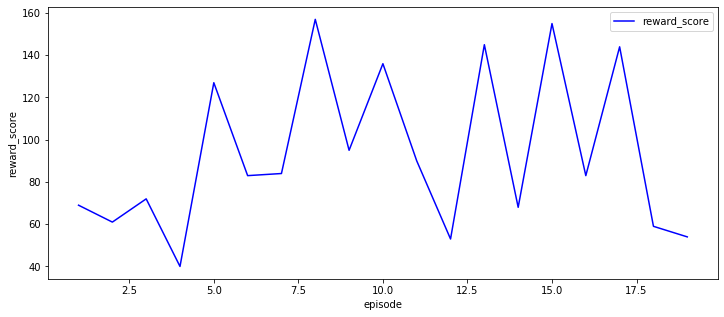

In [109]:
%matplotlib inline
import pandas as pd
import json

training_metrics_file = "training_metrics.json"
training_metrics_path = "{}/{}".format(s3_prefix, training_metrics_file)
wait_for_s3_object(s3_bucket, training_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, training_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
x_axis = 'episode'
y_axis = 'reward_score'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

### Clean up RoboMaker and SageMaker training job

Execute the cells below if you want to kill RoboMaker and SageMaker job.

In [73]:
# Cancelling robomaker job
for job_arn in job_arns:
    robomaker.cancel_simulation_job(job=job_arn)

# Stopping sagemaker training job
sage_session.sagemaker_client.stop_training_job(TrainingJobName=estimator._current_job_name)

{'ResponseMetadata': {'RequestId': '18b6f775-bb4d-4ff9-8633-c86139c424a1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '18b6f775-bb4d-4ff9-8633-c86139c424a1',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 30 Mar 2021 18:10:43 GMT'},
  'RetryAttempts': 0}}

# Evaluation (Time trail, Object avoidance, Head to bot)

In [ ]:
s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"

with open("./src/artifacts/yaml/evaluation_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['MODEL_S3_BUCKET']             = s3_bucket
yaml_config['MODEL_S3_PREFIX']             = s3_prefix
yaml_config['AWS_REGION']                  = aws_region
yaml_config['METRICS_S3_BUCKET']           = s3_bucket
yaml_config['METRICS_S3_OBJECT_KEY']       = "{}/evaluation_metrics.json".format(s3_prefix)
yaml_config['SIMTRACE_S3_BUCKET']          = s3_bucket
yaml_config['SIMTRACE_S3_PREFIX']          = "{}/iteration-data/evaluation".format(s3_prefix)
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['NUMBER_OF_TRIALS']            = "5"
yaml_config['MP4_S3_BUCKET']               = s3_bucket
yaml_config['MP4_S3_OBJECT_PREFIX']        = "{}/iteration-data/evaluation".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

In [ ]:
num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Fail",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [ ]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

### Creating temporary folder top plot metrics

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df['elapsed_time'] = df['elapsed_time_in_milliseconds']/1000
df = df[['trial', 'completion_percentage', 'elapsed_time']]

display(df)

### Clean Up Simulation Application Resource

In [74]:
robomaker.delete_simulation_application(application=simulation_app_arn)

{'ResponseMetadata': {'RequestId': '737b484c-af2d-45f8-b845-f4bb47279d01',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 30 Mar 2021 18:10:53 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '737b484c-af2d-45f8-b845-f4bb47279d01',
   'x-amz-apigw-id': 'dA1zGG6lIAMFZYg=',
   'x-amzn-trace-id': 'Root=1-606369ad-0dc4f55518b7201b7bb4c109'},
  'RetryAttempts': 0}}

### Clean your S3 bucket (Uncomment the awscli commands if you want to do it)

In [75]:
# Uncomment if you only want to clean the s3 bucket
sagemaker_s3_folder = "s3://{}/{}".format(s3_bucket, s3_prefix)
!aws s3 rm --recursive {sagemaker_s3_folder}

robomaker_s3_folder = "s3://{}/{}".format(s3_bucket, job_name)
!aws s3 rm --recursive {robomaker_s3_folder}

robomaker_sim_app = "s3://{}/{}".format(s3_bucket, 'robomaker')
!aws s3 rm --recursive {robomaker_sim_app}

model_output = "s3://{}/{}".format(s3_bucket, s3_bucket)
!aws s3 rm --recursive {model_output}

delete: s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-174853/customer_reward_function.py
delete: s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-174853/ip/done
delete: s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-174853/ip/hyperparameters.json
delete: s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-174853/ip/ip.json
delete: s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-174853/model/model_metadata.json
delete: s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-174853/training_params.yaml
delete: s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-174853/model/.ready
delete: s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-174853/model/0_Step-0.ckpt.index
delete: s3://sagemaker-us-east-1-204747776045/deepracer-notebook-sagemaker-210330-174853/model/0_Step-0.ckpt.data-00000-of-00001
de

# Head-to-head Evaluation

In [ ]:
# S3 bucket
s3_bucket_2 = sage_session.default_bucket()

# Ensure that the S3 prefix contains the keyword 'sagemaker'
# e.g."deepracer-notebook-sagemaker-200422-231836"
# Please provide the second agents s3_prefix
s3_prefix_2 = "[FILL OUT PREFIX]"
if not s3_prefix_2:
    raise Exception("Please provide the second agents s3_prefix and s3_bucket. The prefix would have sagemaker in between")

print("Using s3 bucket {}".format(s3_bucket_2))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket_2, s3_prefix_2))

In [ ]:
s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"

with open("./src/artifacts/yaml/head2head_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['MODEL_S3_BUCKET']             = [s3_bucket,
                                              s3_bucket_2]
yaml_config['MODEL_S3_PREFIX']             = [s3_prefix,
                                              s3_prefix_2]
yaml_config['MODEL_METADATA_FILE_S3_KEY']  =["{}/model/model_metadata.json".format(s3_prefix),
                                             "{}/model/model_metadata.json".format(s3_prefix_2)]
yaml_config['AWS_REGION']                  = aws_region
yaml_config['METRICS_S3_BUCKET']           = [s3_bucket,
                                              s3_bucket_2]
yaml_config['METRICS_S3_OBJECT_KEY']       = ["{}/evaluation_metrics.json".format(s3_prefix),
                                              "{}/evaluation_metrics.json".format(s3_prefix_2)]
yaml_config['SIMTRACE_S3_BUCKET']          = [s3_bucket,
                                              s3_bucket_2]
yaml_config['SIMTRACE_S3_PREFIX']          = ["{}/iteration-data/evaluation".format(s3_prefix),
                                              "{}/iteration-data/evaluation".format(s3_prefix_2)]
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['NUMBER_OF_TRIALS']            = "5"
yaml_config['MP4_S3_BUCKET']               = [s3_bucket,
                                              s3_bucket_2]
yaml_config['MP4_S3_OBJECT_PREFIX']        = ["{}/iteration-data/evaluation".format(s3_prefix),
                                              "{}/iteration-data/evaluation".format(s3_prefix_2)]

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

In [ ]:
num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Fail",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [ ]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

### Creating temporary folder top plot metrics

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df_1 = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df_1['elapsed_time'] = df_1['elapsed_time_in_milliseconds']/1000
df_1 = df_1[['trial', 'completion_percentage', 'elapsed_time']]

display(df_1)

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix_2, evaluation_metrics_file)
wait_for_s3_object(s3_bucket_2, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df_2 = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df_2['elapsed_time'] = df_2['elapsed_time_in_milliseconds']/1000
df_2 = df_2[['trial', 'completion_percentage', 'elapsed_time']]

display(df_2)